In [1]:
import os 
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import anndata as ann

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors


sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1


In [2]:
sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 3
sc.settings.n_jobs = 3
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)

In [3]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [4]:
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [5]:
path_in = '/storage/groups/bcf/projects/SingleCell/10x/projects/theis/nested_stress/rev5/scanpy_AnnData/'

# Introduction

In this notebook, we preprocess the early life stress data from the Chen lab. The full dataset consists of 12 samples from different mice.

We perform the following steps:
1. Load the data
2. Run the QC metrics
3. Threshold and filter genes and cells
4. Normalize with scran
5. Save to file 

The samples come from the following 4 conditions:

In [6]:
sample_condition = {'ELS-37': 'ELS_Stress_1',
 'ELS-7': 'ELS_Stress_2',
 'ELS-11': 'BL_Ctrl_1',
 'ELS-23': 'ELS_Stress_3',
 'ELS-47': 'BL_Stress_1',
 'ELS-71': 'BL_Ctrl_2',
 'ELS-27': 'BL_Stress_2',
 'ELS-105': 'BL_Ctrl_3',
 'ELS-113': 'ELS_Ctrl_1',
 'ELS-73': 'ELS_Ctrl_2',
 'ELS-109': 'ELS_Ctrl_3',
 'ELS-103': 'BL_Stress_3'}

# Read the data

In [7]:
files = os.listdir(path_in)

In [8]:
adatas = list()
for file_idx in enumerate(files):
    adata_tmp = sc.read(path_in + file_idx[1] + '/filtered_feature_bc_matrix.h5ad')
    adata_tmp.obs['sample_id'] = file_idx[1]
    adatas.append(adata_tmp)

In [9]:
adata = adatas[0].concatenate(adatas[1:])

In [10]:
adata.obs['sample_id'].value_counts()

ELS-71     4138
ELS-113    4042
ELS-23     3629
ELS-73     3591
ELS-7      3574
ELS-27     3502
ELS-11     3484
ELS-109    3387
ELS-47     3021
ELS-103    2606
ELS-37     2552
ELS-105    1325
Name: sample_id, dtype: int64

Add the sample origin to the info of the `anndata` object.

In [15]:
adata.obs['sample_name'] = adata.obs['sample_id'].astype('category').cat.rename_categories(sample_condition)  

In [20]:
baseline = [ term.split('_')[0] for term in adata.obs['sample_name']]
condition = [ term.split('_')[1] for term in adata.obs['sample_name']]
full_condition = [term[:-2] for term in adata.obs['sample_name']]

In [21]:
adata.obs['baseline'] = baseline
adata.obs['adult_stress'] = condition
adata.obs['condition'] = full_condition

In [24]:
pd.crosstab(adata.obs['adult_stress'], adata.obs['condition'])

condition     BL_Ctrl  BL_Stress  ELS_Ctrl  ELS_Stress
adult_stress                                          
Ctrl             8947          0     11020           0
Stress              0       9129         0        9755

In [25]:
sc.write(adata=adata, filename = './../data/data_merged.h5ad')

... storing 'sample_id' as categorical
... storing 'baseline' as categorical
... storing 'condition' as categorical
... storing 'adult_stress' as categorical


In [216]:
adata = sc.read('./../data/data_merged.h5ad')

# Quality control

In this section, we compute the quality metrics, namely the number of counts, the number of genes detected, the percentage of mitochondrial reads.

In [108]:
adata = sc.read('./../data/data_merged.h5ad')

In [109]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
mt_gene_index = np.where(mt_gene_mask)[0]
adata.obs['mt_fraction'] = adata.X[:,mt_gene_index].sum(1) / adata.X.sum(1)

Plot QC metrics.

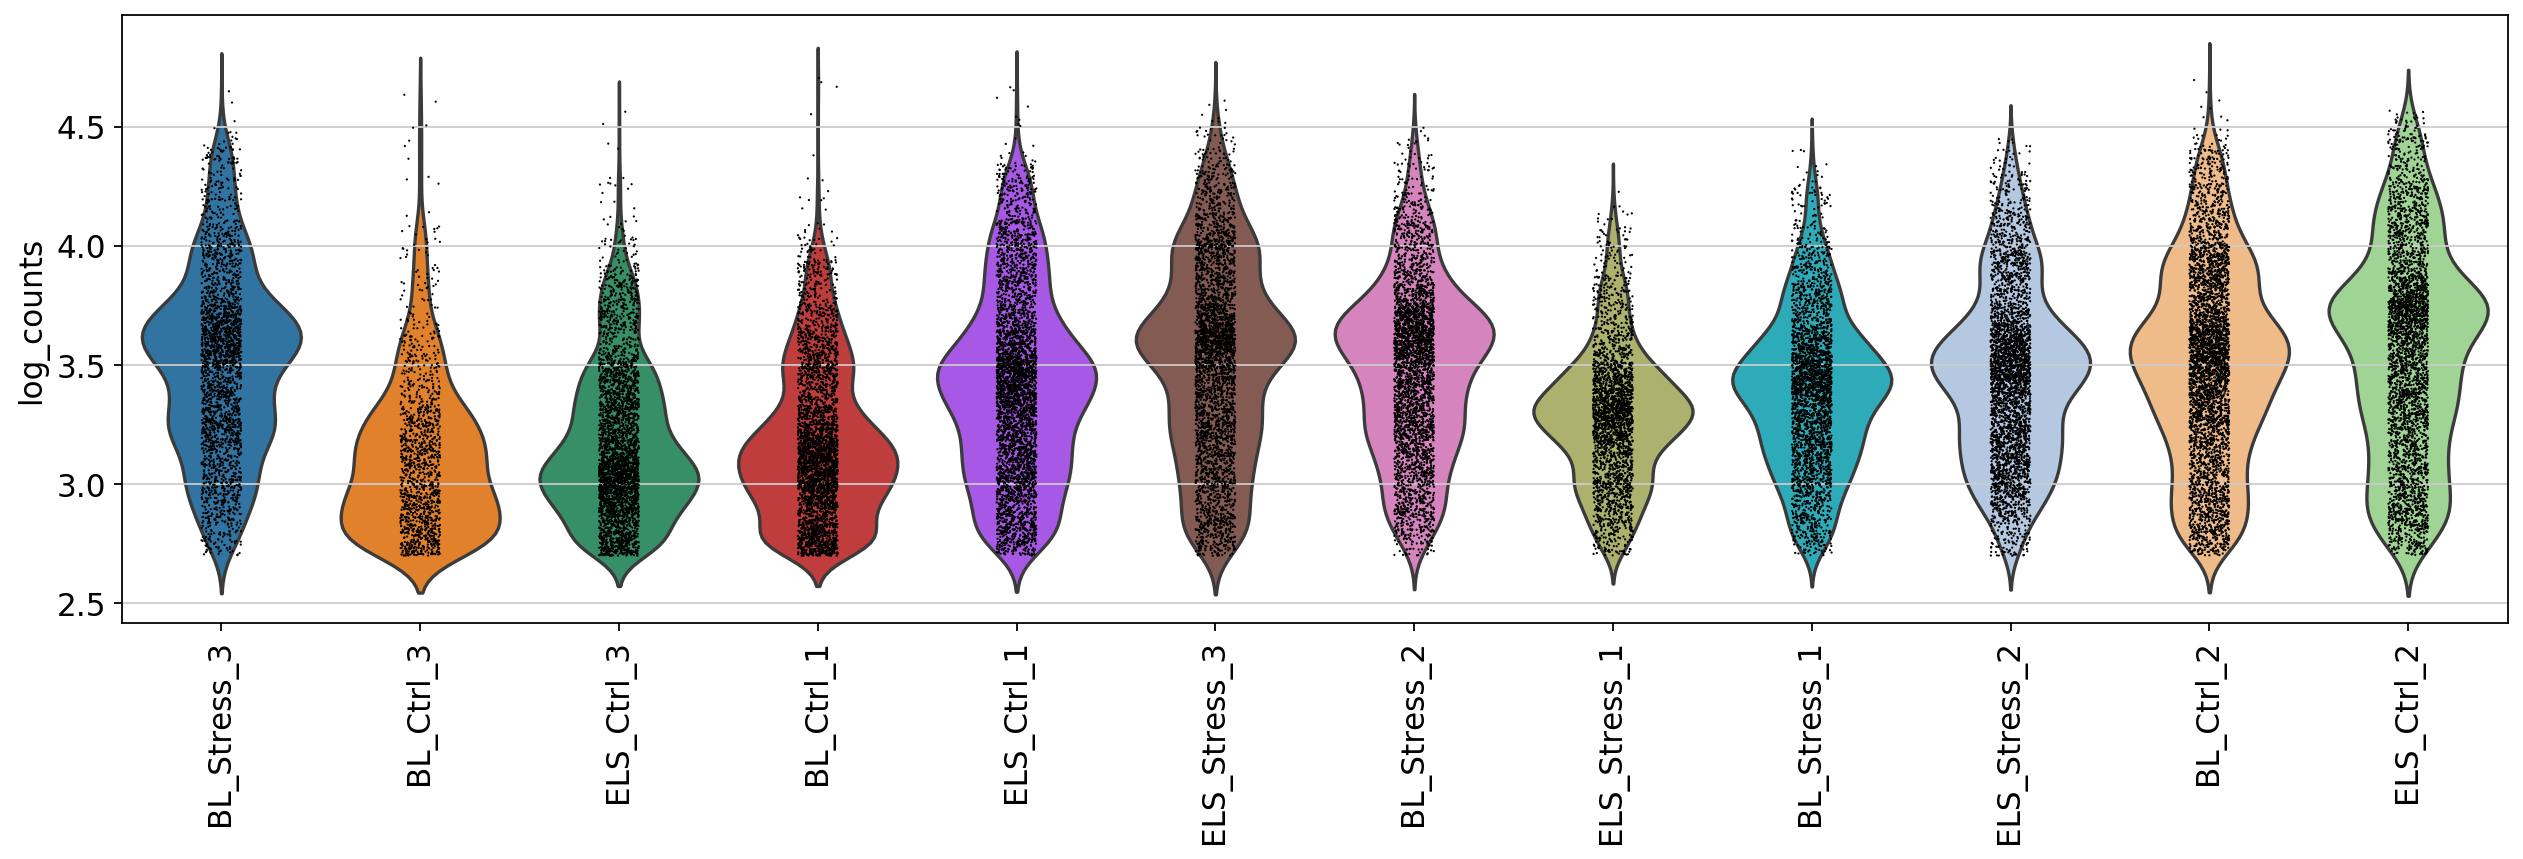

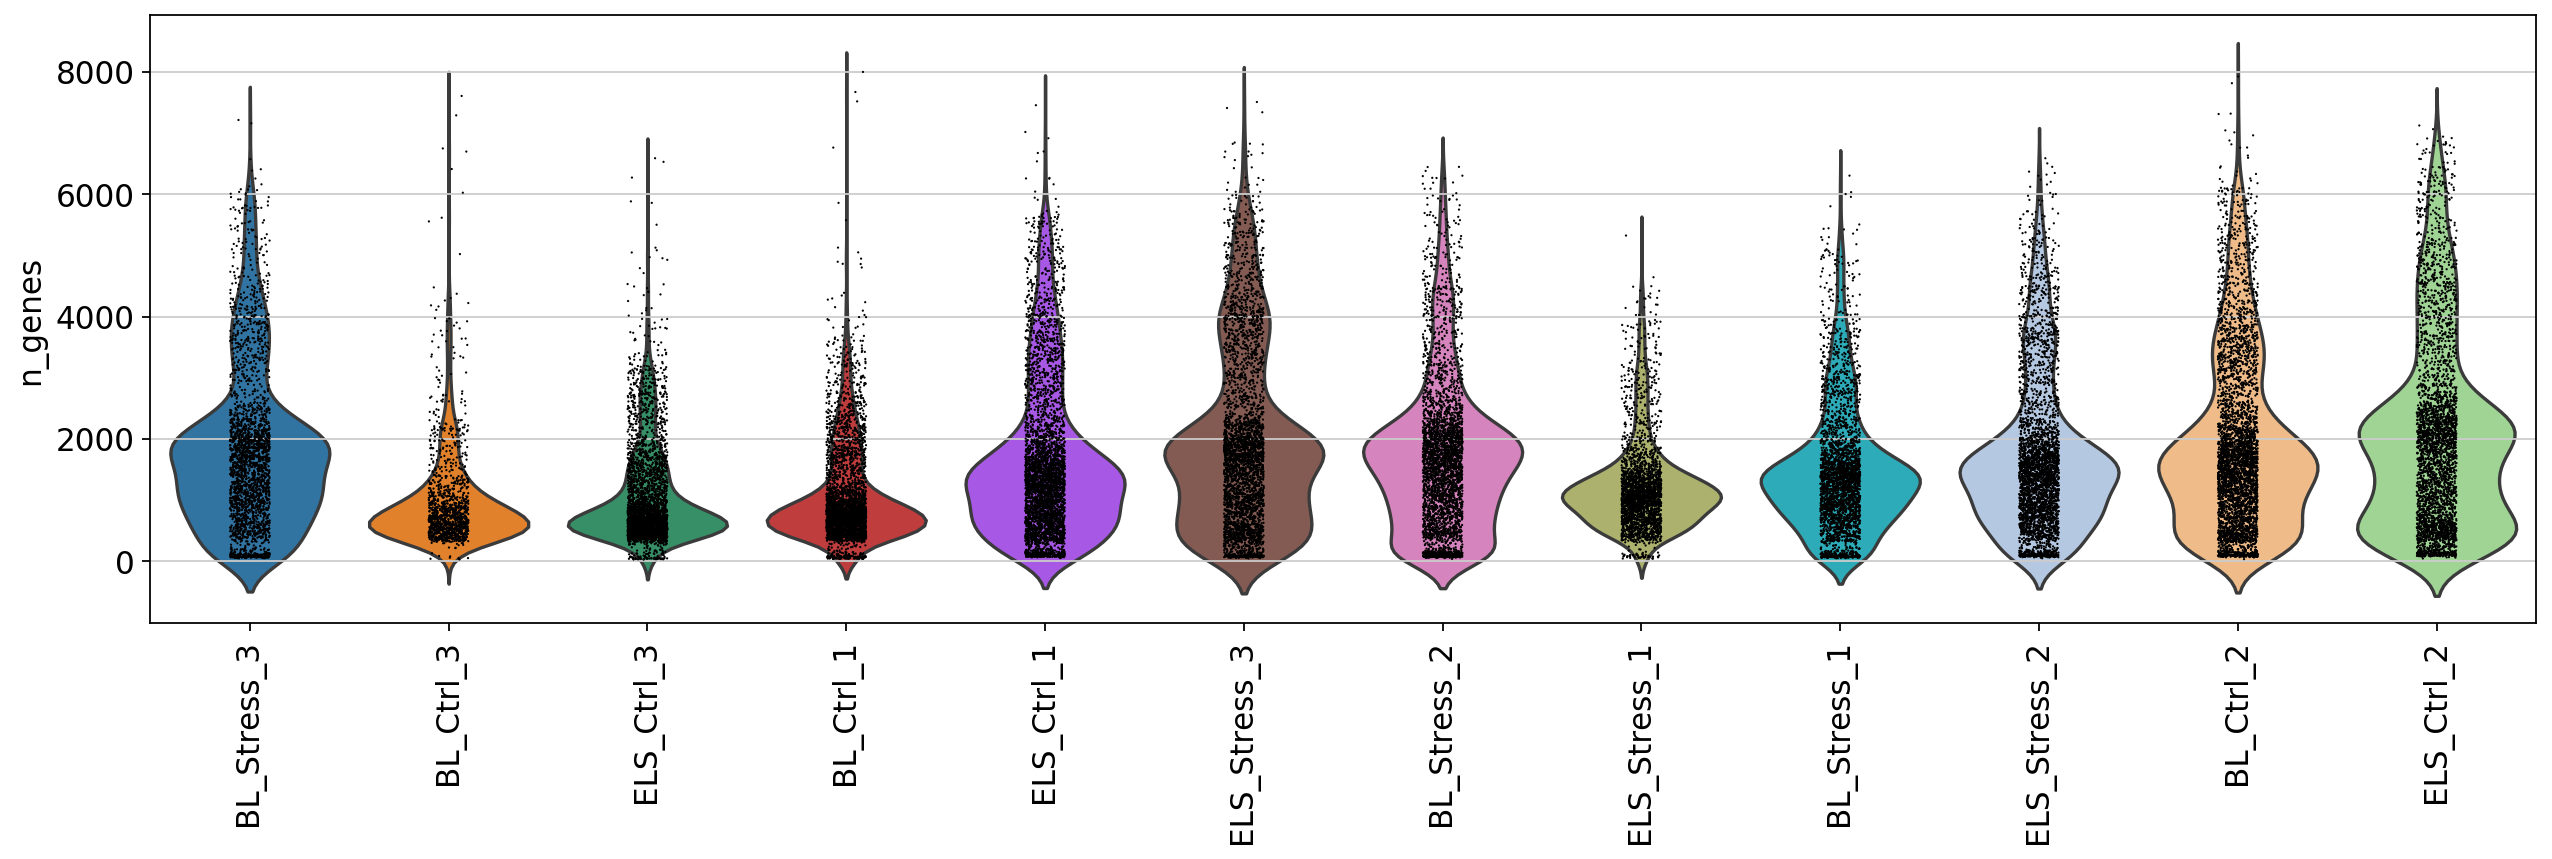

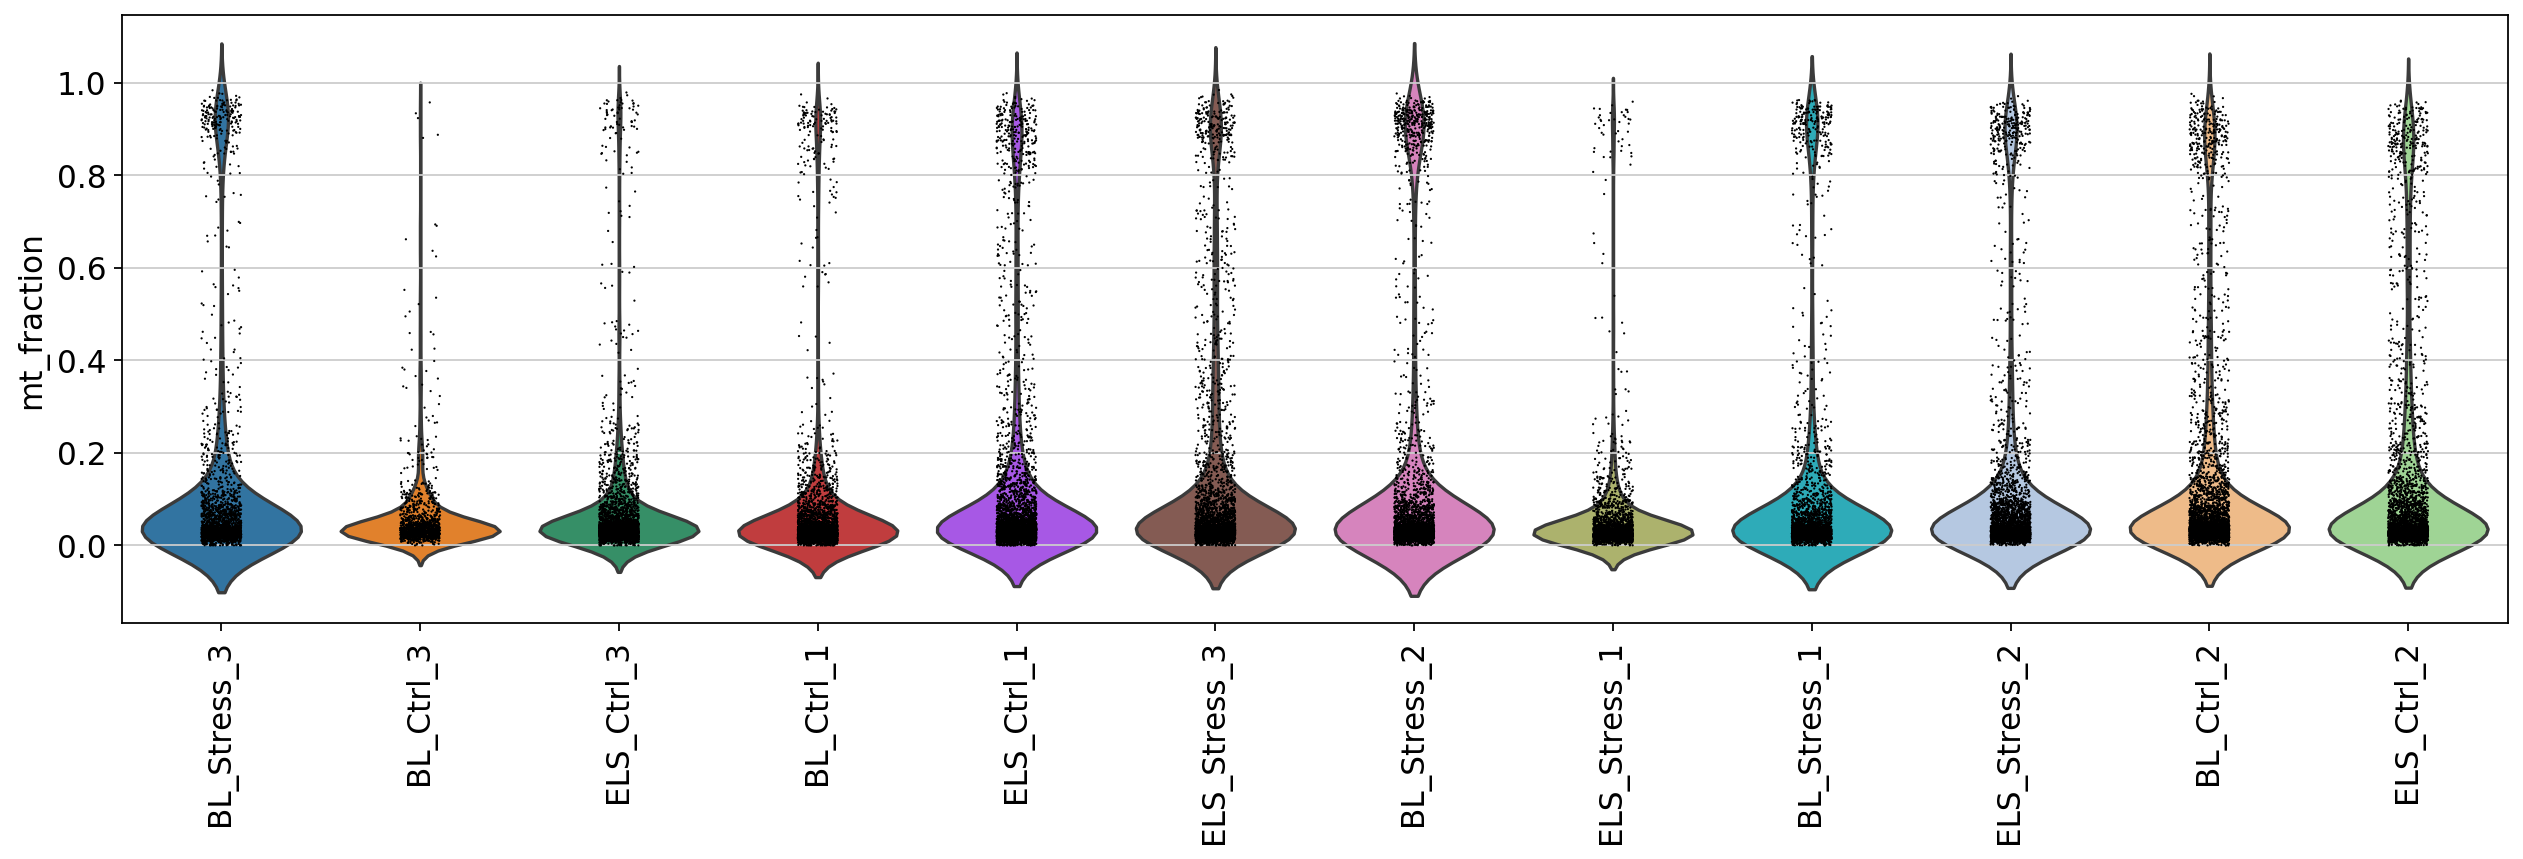

In [76]:
rcParams['figure.figsize']= (15,5)
sc.pl.violin(adata, ['log_counts'], groupby='sample_name', size=1, log=False,rotation=90)
sc.pl.violin(adata, ['n_genes'], groupby='sample_name', size=1, log=False,rotation=90)
sc.pl.violin(adata, ['mt_fraction'], groupby='sample_name', size=1, log=False,rotation=90)

The metrics look overall similar for all samples.

Let us visualise the QC metric in a scatter plot.

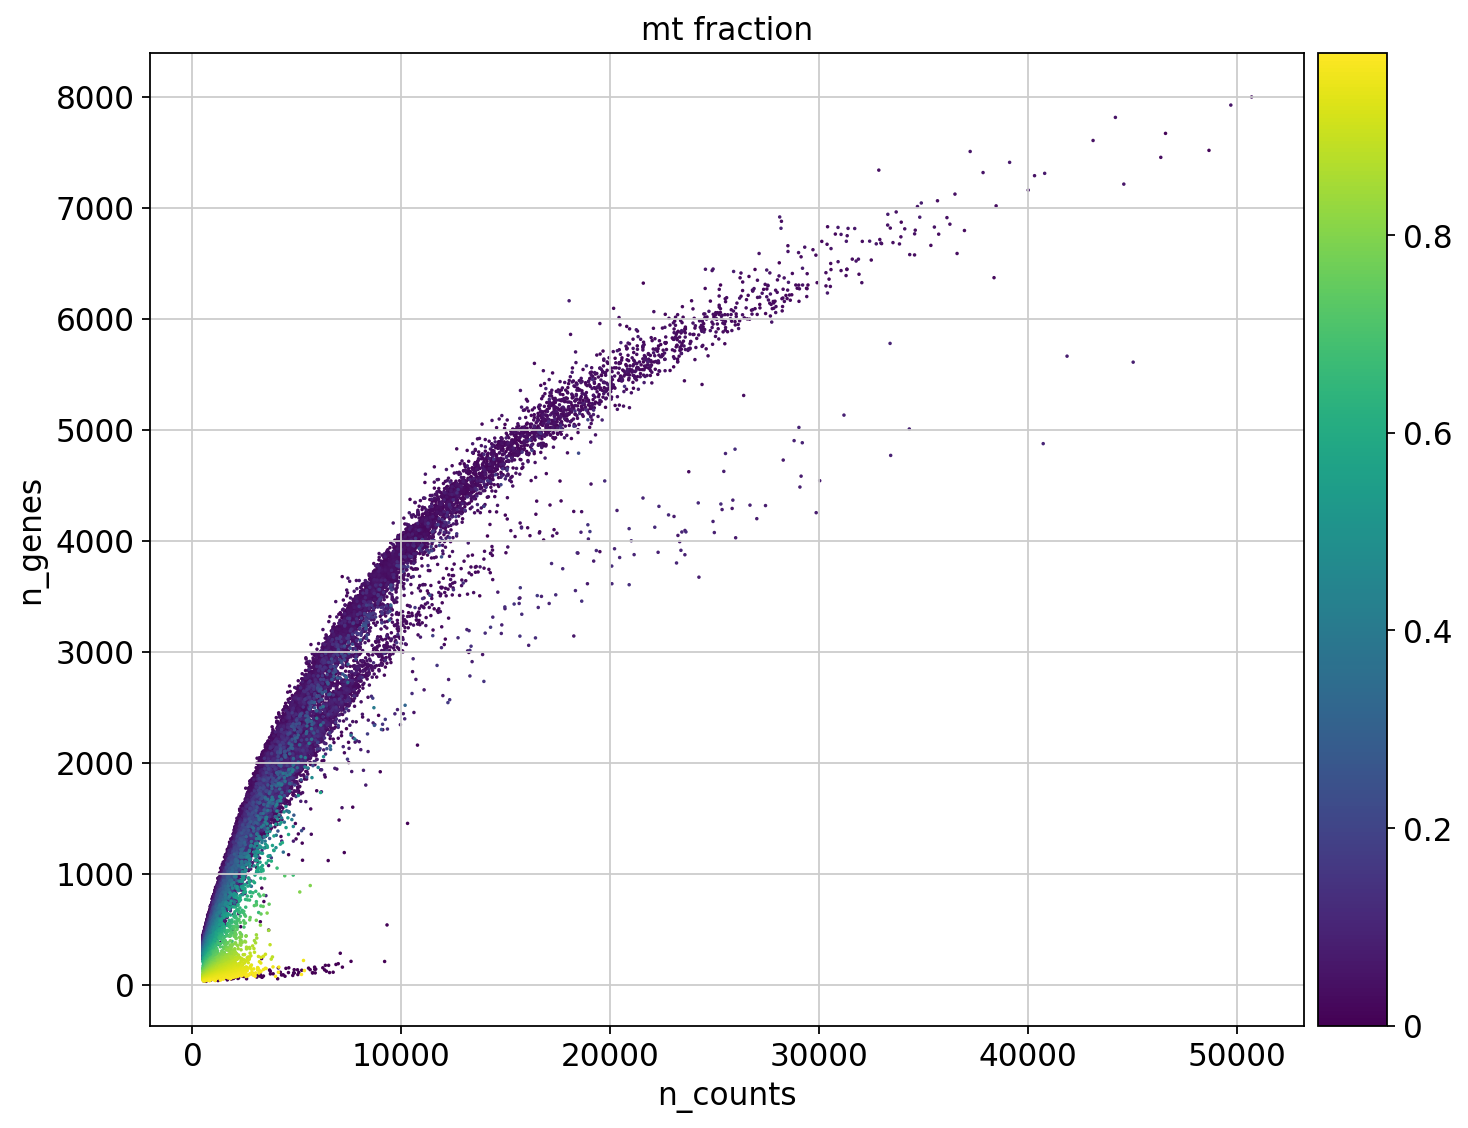

In [77]:
rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata,
              y='n_genes',x='n_counts', color='mt_fraction', size = 10, show=False)

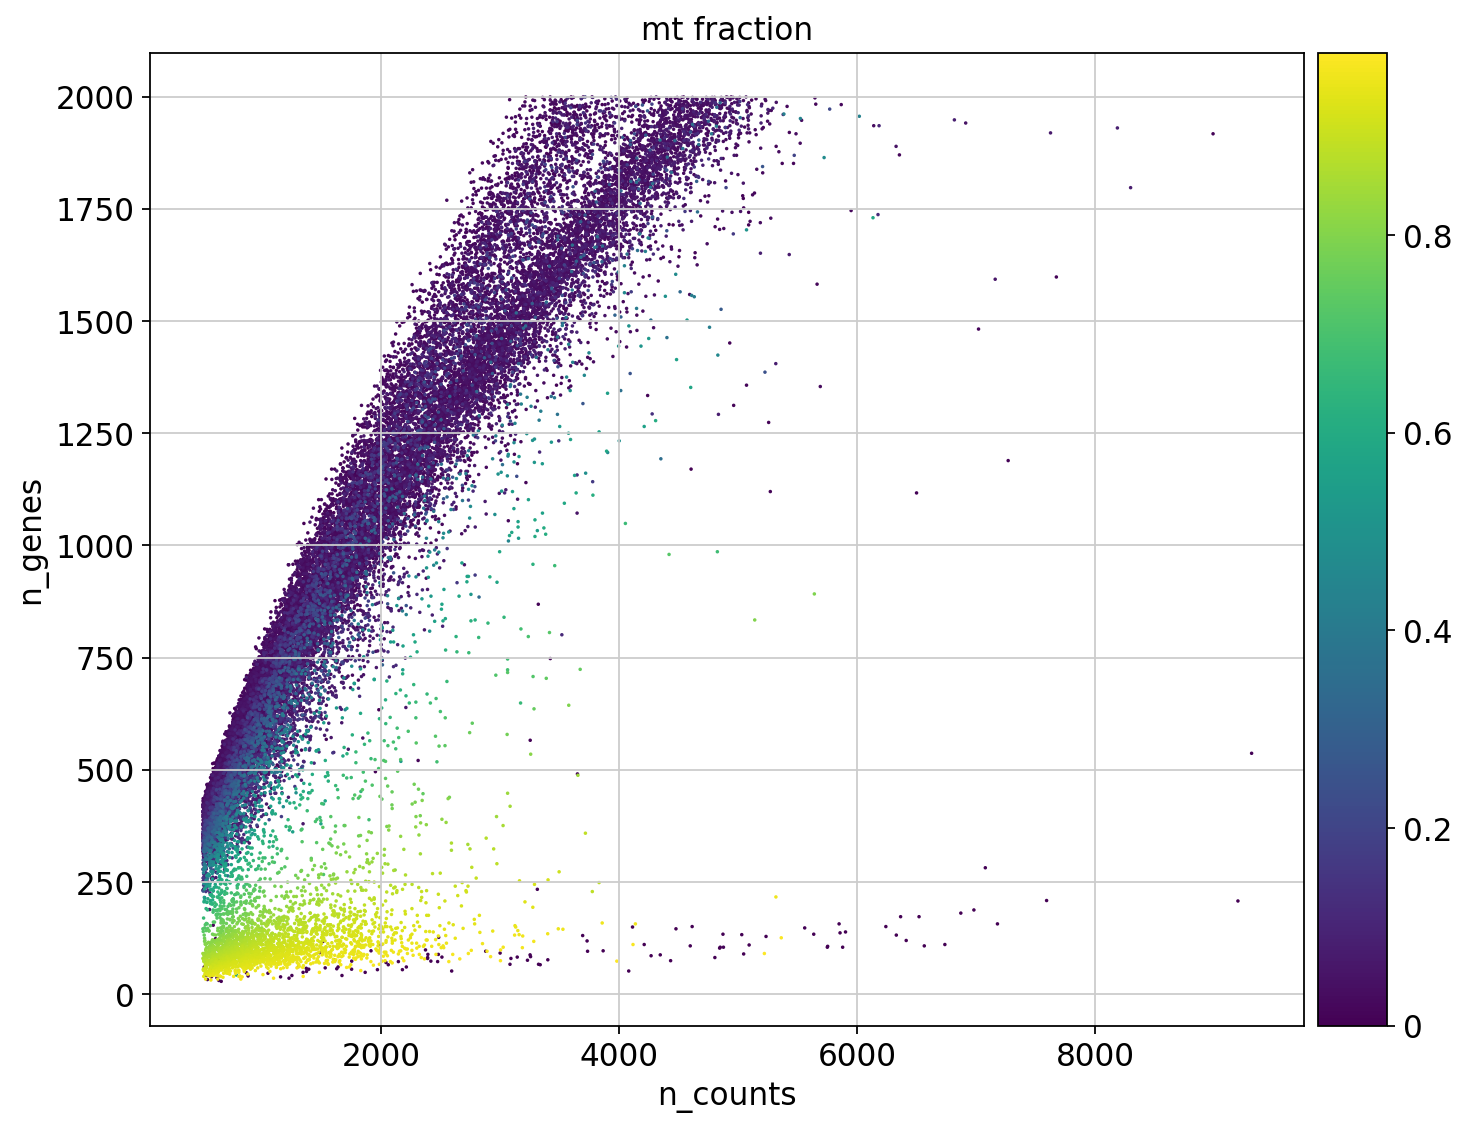

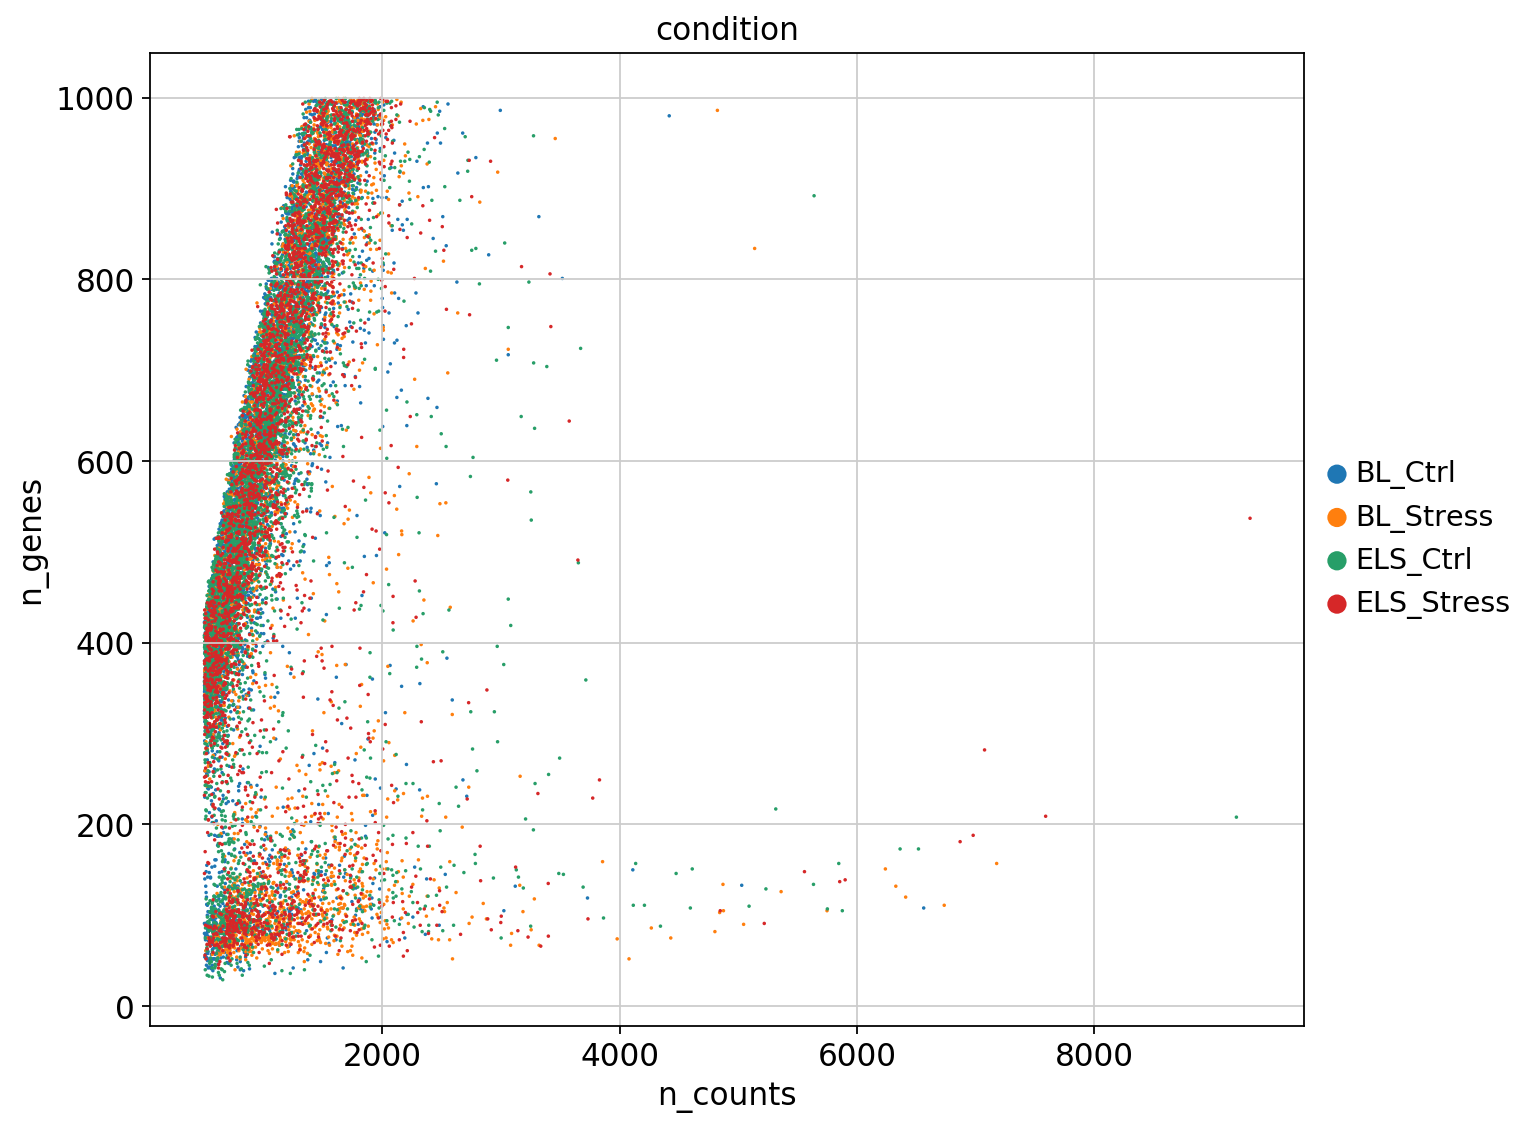

In [78]:
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<2000, adata.obs['n_counts']<10000)],
              y='n_genes',x='n_counts', color='mt_fraction', size = 10, show=False)
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<1000, adata.obs['n_counts']<10000)],
              y='n_genes',x='n_counts', color='condition', size = 10, show=False)

## cell filtering

We start with the mitochondrial reads filter. Here, we apply a the filter of 0.2 for all cells.

In [34]:
adata_tmp = adata.copy()

In [35]:
#Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata_tmp.n_obs))

#get filter idx
high_mt = adata_tmp.obs['mt_fraction'] < 0.2

adata_tmp = adata_tmp[high_mt]
print('Number of cells after MT filter: {:d}'.format(adata_tmp.n_obs))

Total number of cells: 38851
Number of cells after MT filter: 34211


Next, we filter for the number of expressed genes. Here, we see again a different distribution for brain and meninges samples compared to all other samples. 
We try, a minimum of total counts of 2000 for all other samples, and 

In [36]:
#get filter idx
low_count = adata_tmp.obs['n_counts'] > 1000


adata_tmp = adata_tmp[low_count]
print('Number of cells after minimum counts filter: {:d}'.format(adata_tmp.n_obs))

sc.pp.filter_cells(adata_tmp, max_counts=30000)
print('Number of cells after maximum count filter: {:d}'.format(adata_tmp.n_obs))

Number of cells after minimum counts filter: 29191
filtered out 85 cells that have more than 30000 counts


Trying to set attribute `.obs` of view, making a copy.


Number of cells after maximum count filter: 29106


In [38]:
#get filter idx
low_genes = adata_tmp.obs['n_genes'] > 500


adata_tmp = adata_tmp[low_genes]
print('Number of cells after number of expressed genes filter: {:d}'.format(adata_tmp.n_obs))


Number of cells after number of expressed genes filter: 28957


## gene filter

In [39]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_tmp.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_tmp, min_cells=10)
print('Number of genes after cell filter: {:d}'.format(adata_tmp.n_vars))

Total number of genes: 31538
filtered out 12610 genes that are detected in less than 10 cells


Trying to set attribute `.var` of view, making a copy.


Number of genes after cell filter: 18928


## Doublet detection

In [40]:
import scrublet as scr
import scipy.io
import time

In [41]:
adata_tmp.obs['doublet_score']= np.zeros(adata_tmp.shape[0])
adata_tmp.obs['doublet'] = np.zeros(adata_tmp.shape[0])

In [42]:
# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.02 
sim_doublet_ratio = 3
n_neighbors = 15

for batch in enumerate(adata_tmp.obs['sample_id'].cat.categories):
    t0 = time.time()
    idx = np.flatnonzero(adata_tmp.obs['sample_id']==batch[1])
    scrub = scr.Scrublet(counts_matrix = adata_tmp[idx,:].X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)
    adata_tmp.obs['doublet_score'].iloc[idx] = doublet_scores
    adata_tmp.obs['doublet'].iloc[idx] = predicted_doublets
    t1 = time.time()
    print('Elapsed time: {:.1f} seconds'.format(t1 - t0))

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.13
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 50.4%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 2.2%
Elapsed time: 3.5 seconds
Elapsed time: 3.6 seconds
Preprocessing...


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.13
Detected doublet rate = 1.4%
Estimated detectable doublet fraction = 45.9%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.0%
Elapsed time: 1.4 seconds
Elapsed time: 1.5 seconds
Preprocessing...


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.09
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 60.2%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 2.4%
Elapsed time: 2.6 seconds
Elapsed time: 2.8 seconds
Preprocessing...


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 0.9%
Estimated detectable doublet fraction = 49.6%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 1.9%
Elapsed time: 2.3 seconds
Elapsed time: 2.5 seconds
Preprocessing...


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.09
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 57.5%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 2.8%
Elapsed time: 1.3 seconds
Elapsed time: 1.4 seconds
Preprocessing...


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.08
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 64.0%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.4%
Elapsed time: 1.8 seconds
Elapsed time: 2.0 seconds
Preprocessing...


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.08
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 64.0%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.1%
Elapsed time: 3.0 seconds
Elapsed time: 3.1 seconds
Preprocessing...


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.10
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 56.0%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 2.3%
Elapsed time: 2.5 seconds
Elapsed time: 2.7 seconds
Preprocessing...


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 45.0%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 1.2%
Elapsed time: 1.7 seconds
Elapsed time: 1.9 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 31.6%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 2.6%
Elapsed time: 0.5 seconds
Elapsed time: 0.5 seconds
Preprocessing...


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.12
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 45.7%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 2.9%
Elapsed time: 1.4 seconds
Elapsed time: 1.5 seconds
Preprocessing...


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.13
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 46.6%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 2.3%
Elapsed time: 2.6 seconds
Elapsed time: 2.7 seconds


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


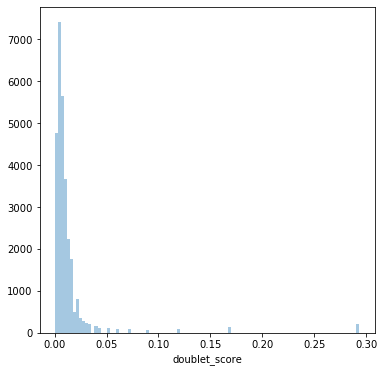

In [43]:
rcParams['figure.figsize']=(6,6)
sb.distplot(adata_tmp.obs['doublet_score'], bins=100, kde=False)

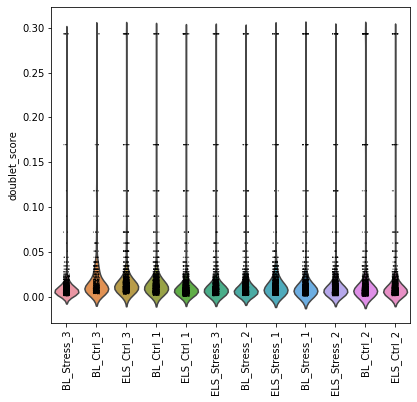

In [44]:
sc.pl.violin(adata_tmp, ['doublet_score'], groupby='sample_name', size=1, log=False,rotation=90)

### filter doublets

Scrublet proposed a different threshold than we would choose based upon the histogram plot of the doublet scores.

In [45]:
thr = 0.05
ix_filt = adata_tmp.obs['doublet_score']<=thr

adata_tmp = adata_tmp[ix_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata_tmp.n_obs))

Number of cells after doublet filter: 28167


# QC after filtering

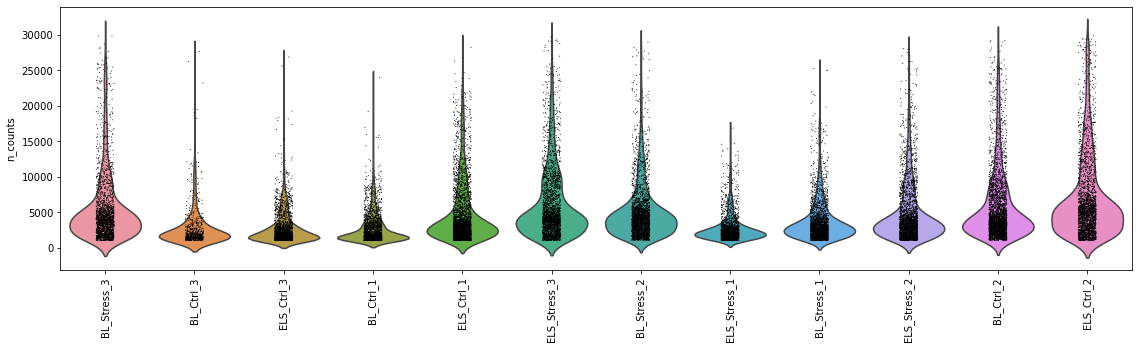

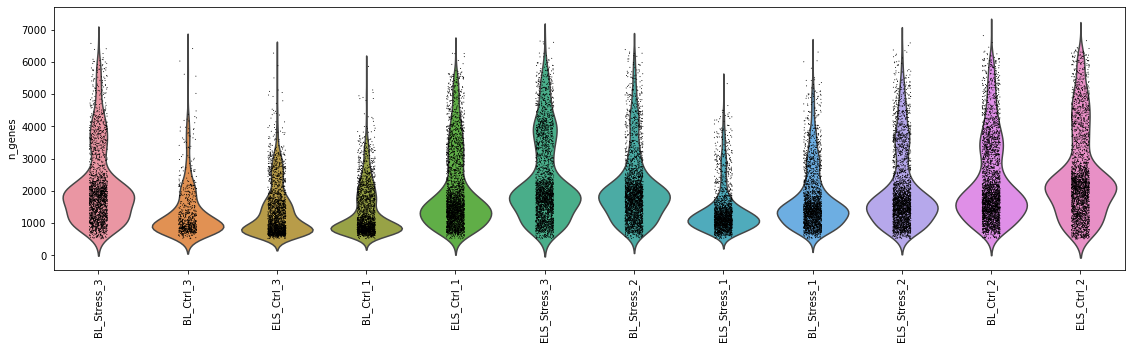

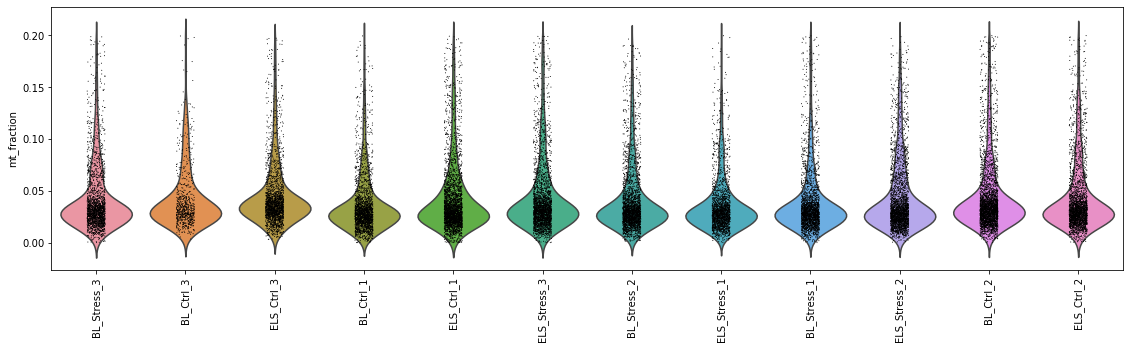

mean_genes  median_genes  mean_counts  median_counts
sample_name                                                        
BL_Stress_3   2147.983847        1854.0  5549.319336         4014.0
BL_Ctrl_3     1363.736152        1029.0  2771.001465         1814.0
ELS_Ctrl_3    1394.895091        1110.0  2773.678955         1938.0
BL_Ctrl_1     1388.079212        1052.0  2716.803223         1796.0
ELS_Ctrl_1    2008.733333        1559.5  4825.596191         3115.5
ELS_Stress_3  2378.995938        1937.5  6135.767090         4338.0
BL_Stress_2   2073.053666        1837.0  5080.520020         4010.5
ELS_Stress_1  1377.432806        1163.0  2778.636475         2144.5
BL_Stress_1   1734.470987        1442.0  3781.526855         2839.0
ELS_Stress_2  2022.522442        1628.0  4781.268066         3352.0
BL_Ctrl_2     2327.254138        1879.0  5888.777832         4058.0
ELS_Ctrl_2    2498.222607        2154.0  6896.215332         5136.0

In [46]:
rcParams['figure.figsize']= (15,5)
sc.pl.violin(adata_tmp, ['n_counts'], 
             groupby='sample_name', size=1, log=False,rotation=90)
sc.pl.violin(adata_tmp, ['n_genes'], 
             groupby='sample_name', size=1, log=False,rotation=90)
sc.pl.violin(adata_tmp, ['mt_fraction'], 
             groupby='sample_name', size=1, log=False,rotation=90)

df = adata_tmp.obs[['n_genes','n_counts','sample_name']]
df_all = pd.DataFrame(df.groupby(by='sample_name')['n_genes'].apply(np.mean).values,
                      index=df.groupby(by='sample_name')['n_genes'].apply(np.mean).index,
                      columns=['mean_genes'])

df_all['median_genes']=df.groupby(by='sample_name')['n_genes'].apply(np.median).values
df_all['mean_counts']=df.groupby(by='sample_name')['n_counts'].apply(np.mean).values
df_all['median_counts']=df.groupby(by='sample_name')['n_counts'].apply(np.median).values
df_all

## Visual sanity check 

Before we proceed with the scran normalisation, we should remove remaining outliers and low quality cells, which have not been detected and or filtered, yet. 

In [47]:
sc.pp.normalize_total(adata_tmp,target_sum = 1e4)
sc.pp.log1p(adata_tmp)

Normalizing counts per cell.
    finished (0:00:00):normalized adata.X


In [48]:
sc.tl.pca(adata_tmp, svd_solver='arpack')
sc.pp.neighbors(adata_tmp)

computing PCA with n_comps = 50
    finished (0:00:20)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../../../../../../../home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        lef

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:09)


In [49]:
sc.tl.louvain(adata_tmp, resolution=0.5)
sc.tl.umap(adata_tmp)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 27 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:04)
computing UMAP


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:35)


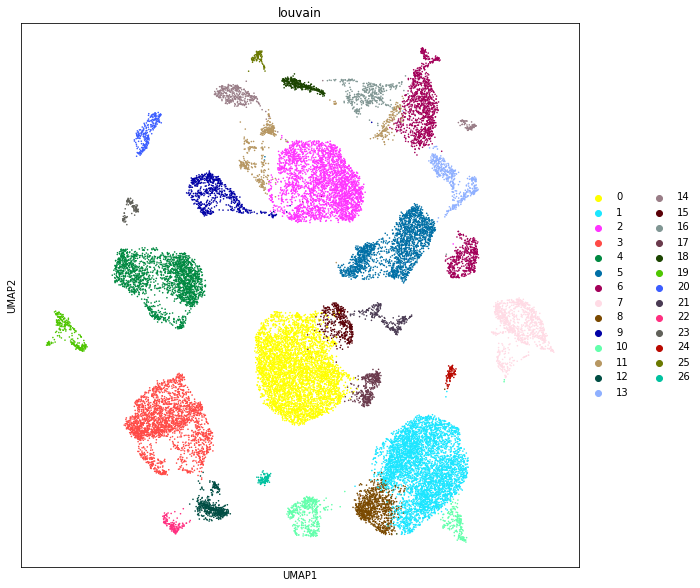

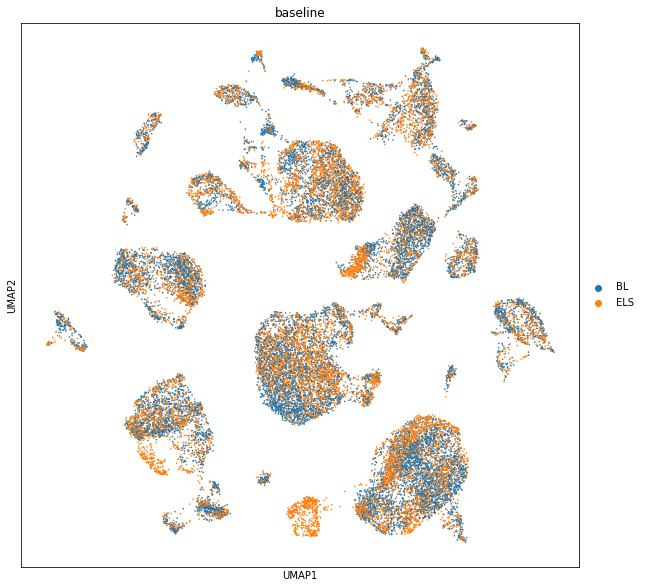

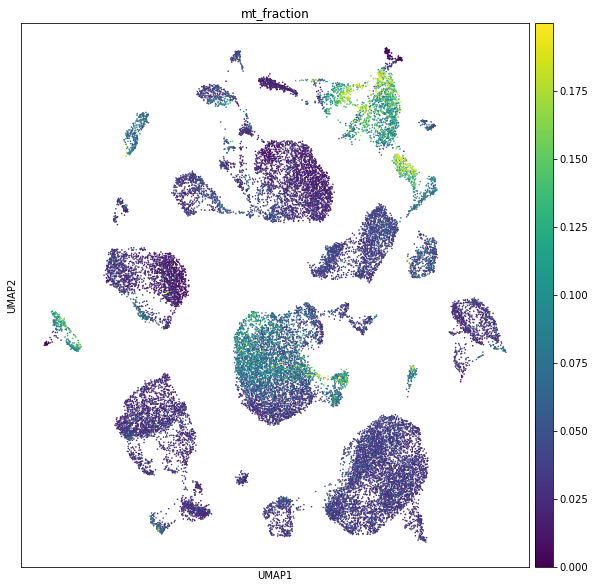

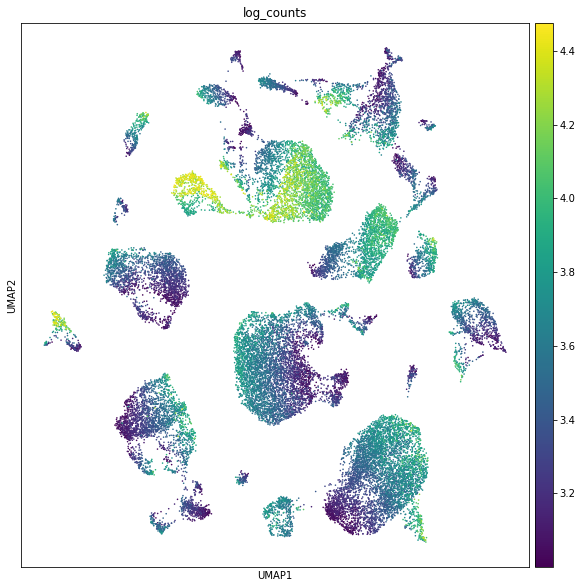

In [51]:
rcParams['figure.figsize']=(10,10)
sc.pl.umap(adata_tmp, color='louvain', size=10)
sc.pl.umap(adata_tmp, color='baseline', size=10)
sc.pl.umap(adata_tmp, color='mt_fraction', size=10)
sc.pl.umap(adata_tmp, color='log_counts', size=10)

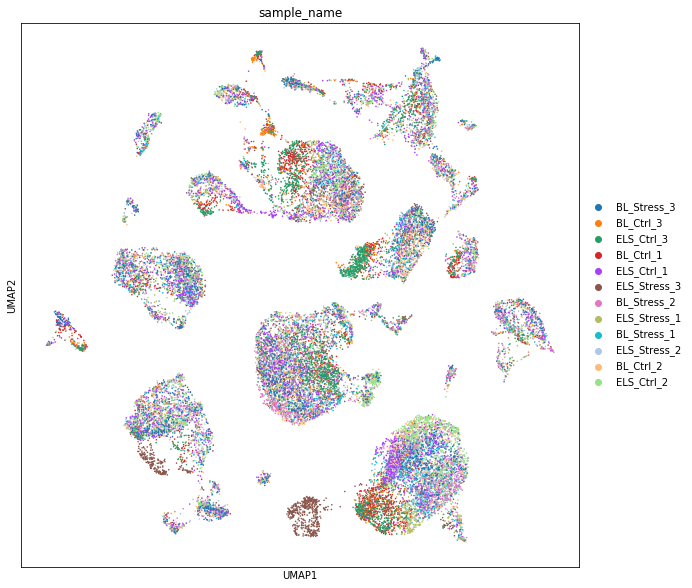

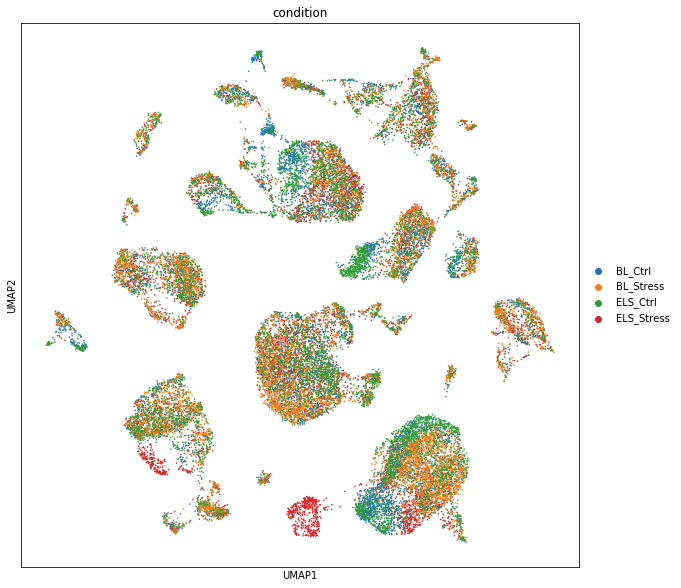

In [52]:
rcParams['figure.figsize']=(10,10)
sc.pl.umap(adata_tmp, color='sample_name', size=10)
sc.pl.umap(adata_tmp, color='condition', size=10)

# Normalisation

In [53]:
sc.write(adata=adata_tmp, filename='tmp.h5ad')

In [6]:
adata_tmp = sc.read('tmp.h5ad')

In [7]:
%%R

# Load all the R libraries we will be using in the notebook
library(scran)

Perform the clustering.

In [8]:
a,b = np.unique(adata_tmp.obs['sample_name'], return_index=True)
sample_id = a[np.argsort(b)]

In [19]:
adatas =[]
for sample in enumerate(a[np.argsort(b)]):
    print(sample[1])
    adata_pp = adata_tmp[adata_tmp.obs['sample_name']==sample[1]].copy()
    #sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e4)
    #sc.pp.log1p(adata_pp)
    sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
    sc.pp.neighbors(adata_pp)
    sc.tl.louvain(adata_pp, key_added='groups', resolution=0.2)
    #Preprocess variables for scran normalization
    adatas.append(adata_pp)

ELS_Stress_1
computing PCA with n_comps = 15
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)
ELS_Stress_2
computing PCA with n_comps = 15
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)
BL_Ctrl_1
computing PCA with n_comps = 15
    finished (0:00:00)
computing ne

## Run scran normalisation for all samples

In [20]:
#Preprocess variables for scran normalization
input_groups = adatas[0].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['sample_name']==sample_id[0]].X.T

Merge smallest cluster with rest.

In [24]:
input_groups[input_groups=='8'] = '0'

In [26]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

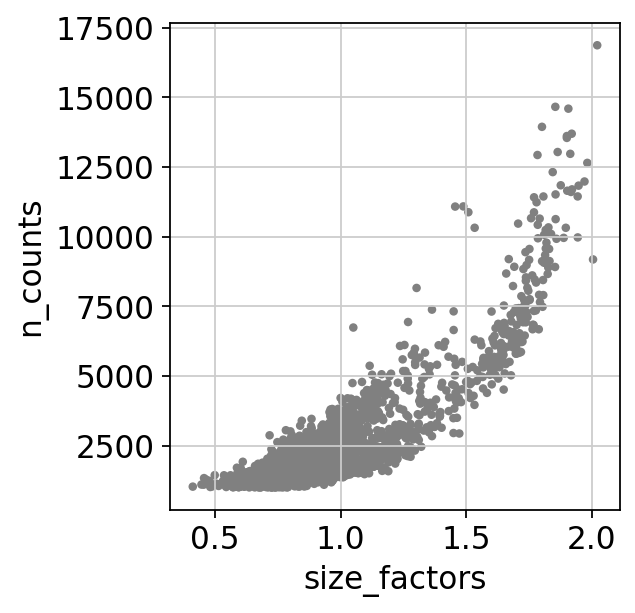

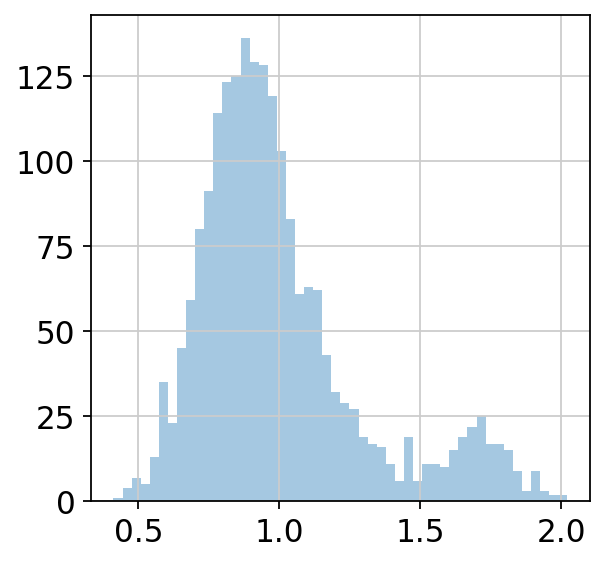

In [27]:
# Visualize the estimated size factors
adatas[0].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[0], 'size_factors', 'n_counts')

sb.distplot(size_factors, bins=50, kde=False)
pl.show()

In [28]:
#Preprocess variables for scran normalization
input_groups = adatas[1].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['sample_name']==sample_id[1]].X.T

In [29]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

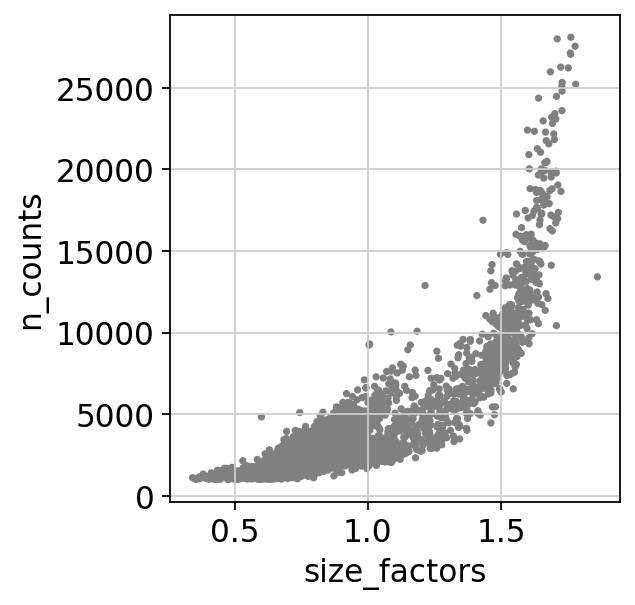

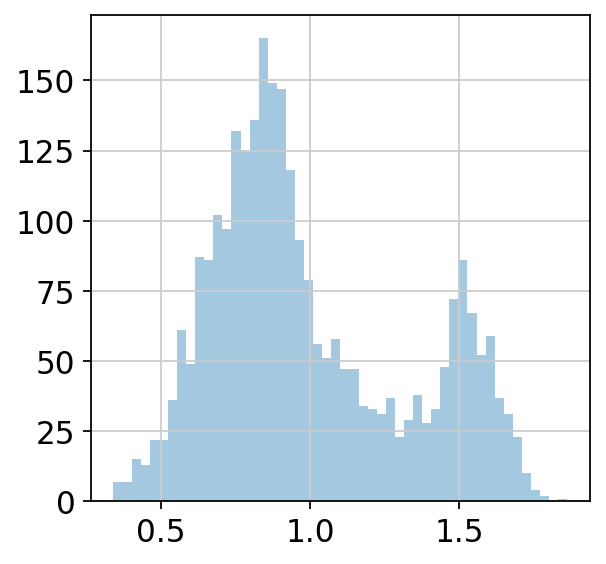

In [30]:
# Visualize the estimated size factors
adatas[1].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[1], 'size_factors', 'n_counts')

sb.distplot(size_factors, bins=50, kde=False)
pl.show()

In [31]:
#Preprocess variables for scran normalization
input_groups = adatas[2].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['sample_name']==sample_id[2]].X.T

In [32]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

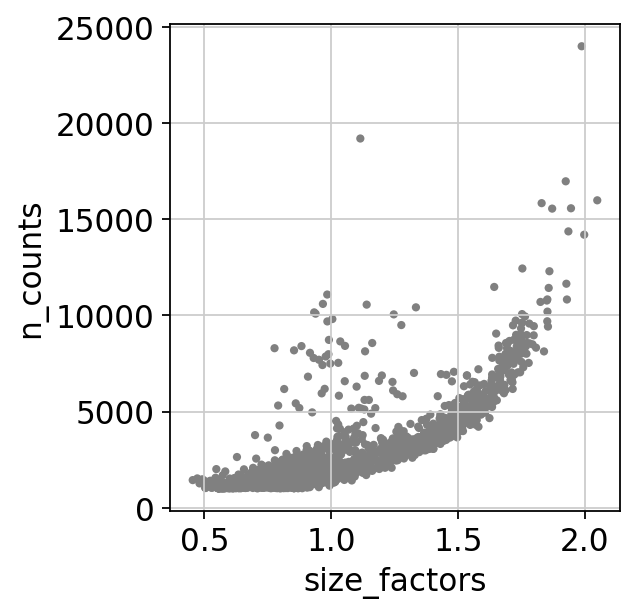

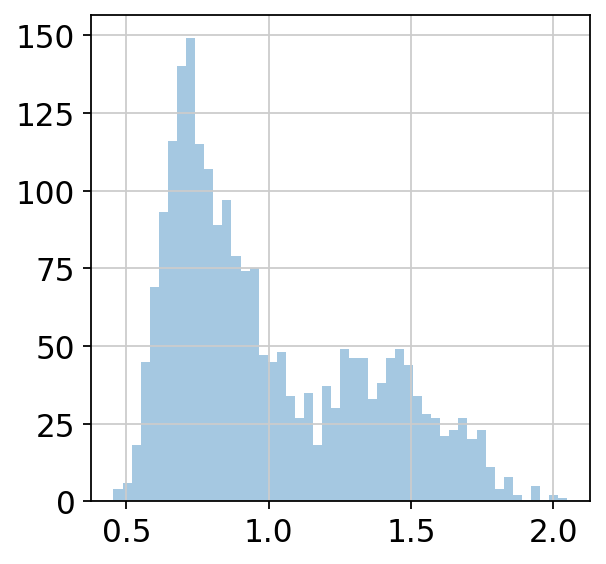

In [33]:
# Visualize the estimated size factors
adatas[2].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[2], 'size_factors', 'n_counts')

sb.distplot(size_factors, bins=50, kde=False)
pl.show()

In [34]:
#Preprocess variables for scran normalization
input_groups = adatas[3].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['sample_name']==sample_id[3]].X.T

In [37]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.3)

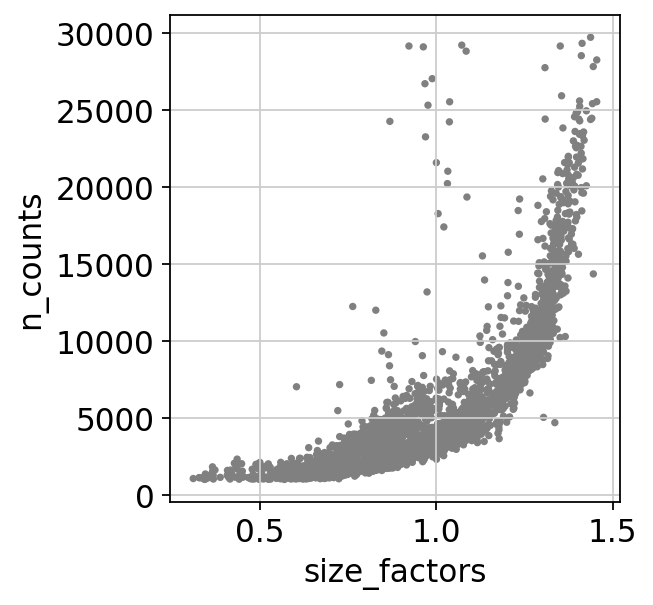

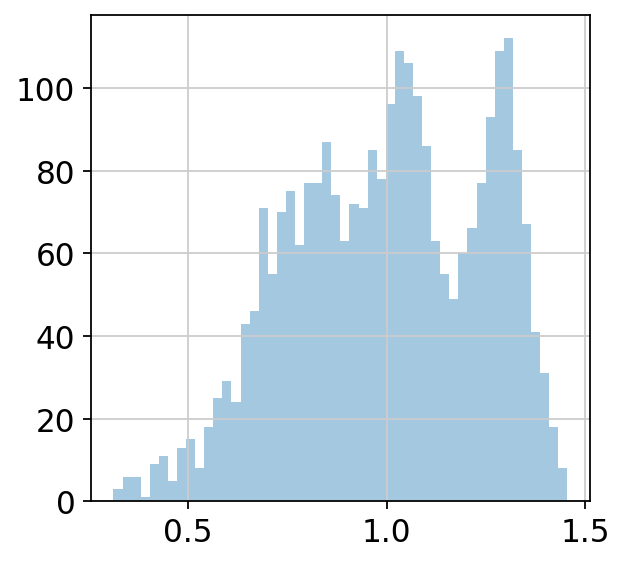

In [38]:
# Visualize the estimated size factors
adatas[3].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[3], 'size_factors', 'n_counts')

sb.distplot(size_factors, bins=50, kde=False)
pl.show()

In [39]:
#Preprocess variables for scran normalization
input_groups = adatas[4].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['sample_name']==sample_id[4]].X.T

In [40]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

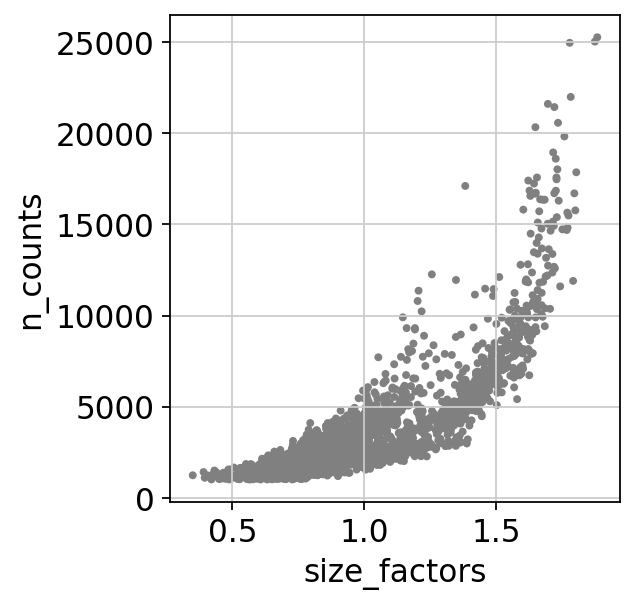

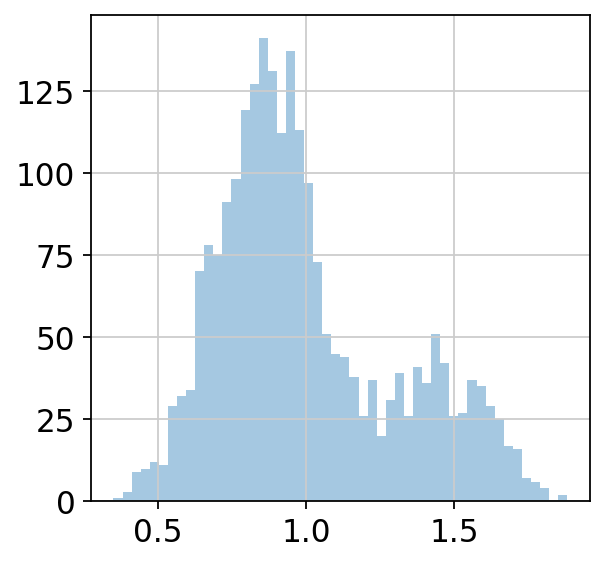

In [41]:
# Visualize the estimated size factors
adatas[4].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[4], 'size_factors', 'n_counts')

sb.distplot(size_factors, bins=50, kde=False)
pl.show()

In [42]:
#Preprocess variables for scran normalization
input_groups = adatas[5].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['sample_name']==sample_id[5]].X.T

In [45]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

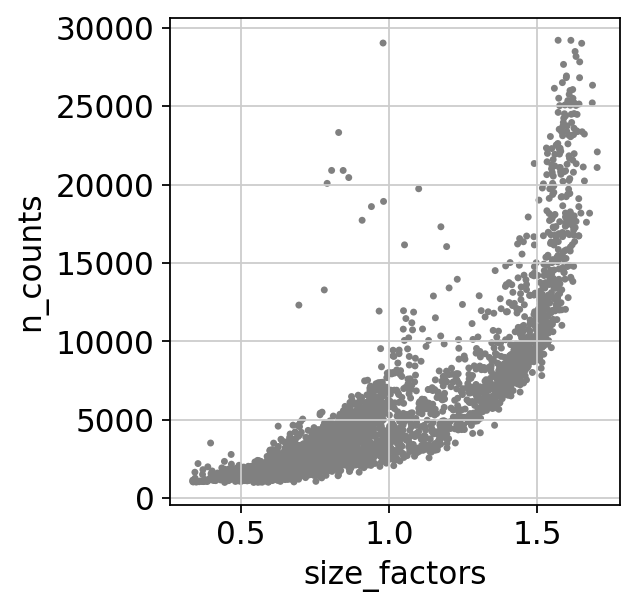

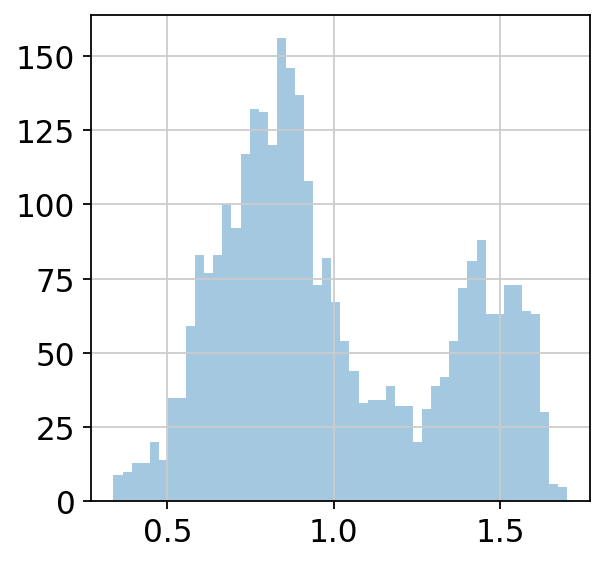

In [46]:
# Visualize the estimated size factors
adatas[5].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[5], 'size_factors', 'n_counts')

sb.distplot(size_factors, bins=50, kde=False)
pl.show()

In [47]:
#Preprocess variables for scran normalization
input_groups = adatas[6].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['sample_name']==sample_id[6]].X.T

In [51]:
input_groups.value_counts()

0     636
1     588
2     264
3     251
4     246
5     243
6     166
7     110
8      93
9      34
10     15
Name: groups, dtype: int64

In [52]:
input_groups[input_groups=='10'] = '0'

In [53]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

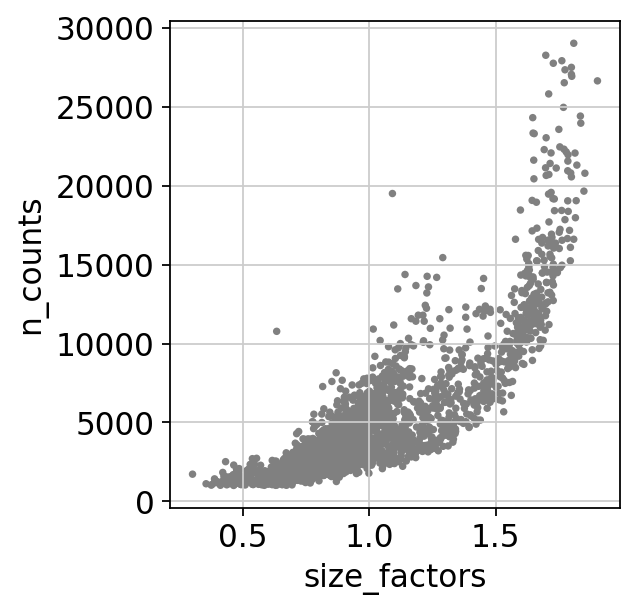

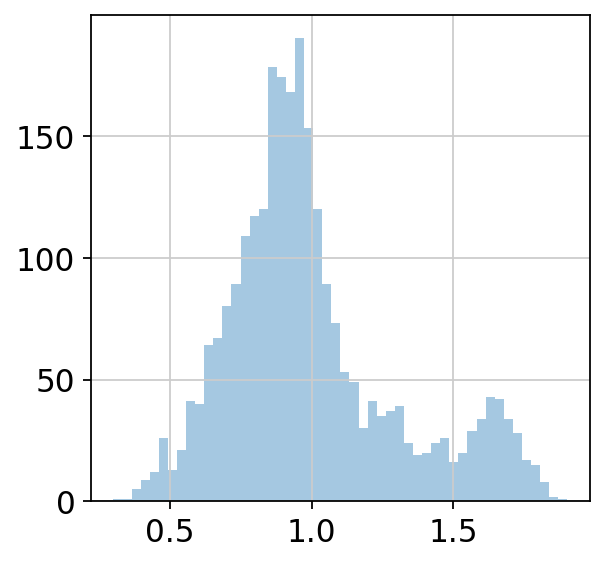

In [54]:
# Visualize the estimated size factors
adatas[6].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[6], 'size_factors', 'n_counts')

sb.distplot(size_factors, bins=50, kde=False)
pl.show()

In [55]:
#Preprocess variables for scran normalization
input_groups = adatas[7].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['sample_name']==sample_id[7]].X.T

In [56]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

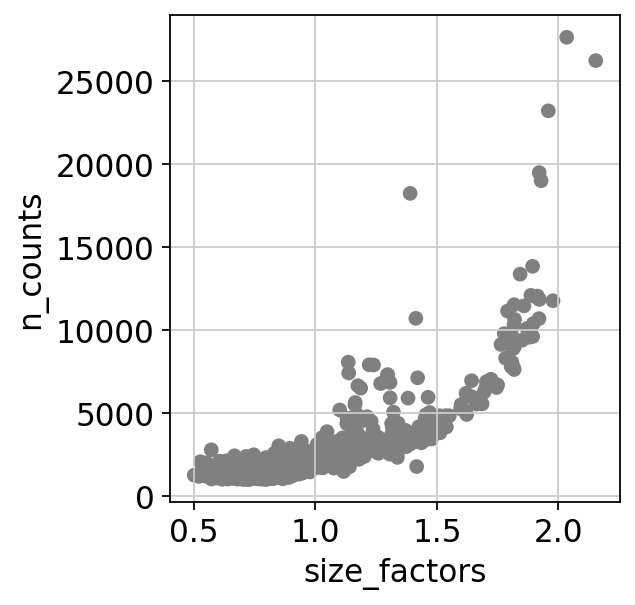

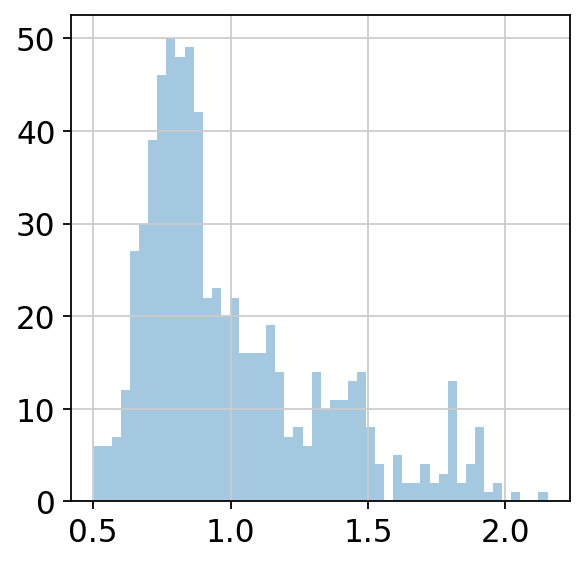

In [57]:
# Visualize the estimated size factors
adatas[7].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[7], 'size_factors', 'n_counts')

sb.distplot(size_factors, bins=50, kde=False)
pl.show()

In [58]:
#Preprocess variables for scran normalization
input_groups = adatas[8].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['sample_name']==sample_id[8]].X.T

In [59]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

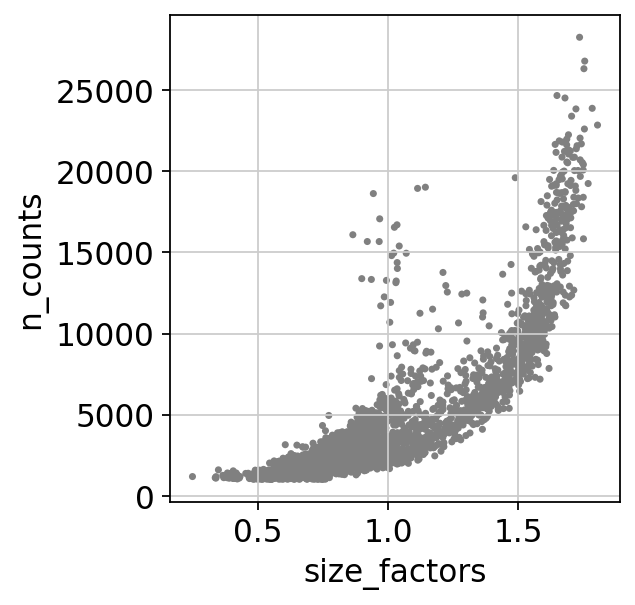

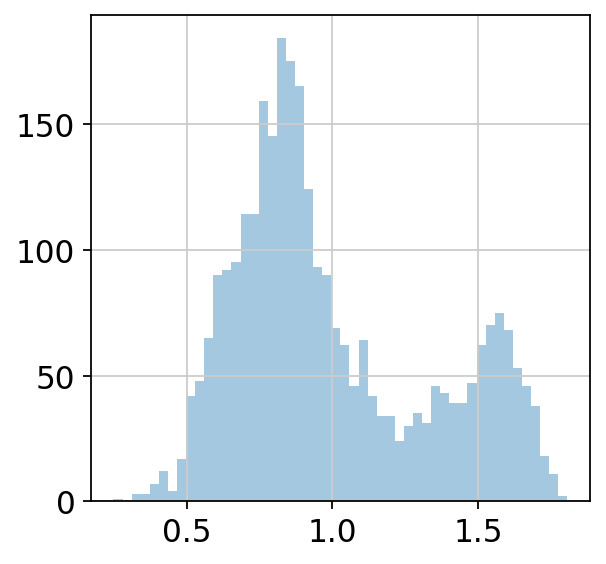

In [60]:
# Visualize the estimated size factors
adatas[8].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[8], 'size_factors', 'n_counts')

sb.distplot(size_factors, bins=50, kde=False)
pl.show()

In [61]:
#Preprocess variables for scran normalization
input_groups = adatas[9].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['sample_name']==sample_id[9]].X.T

In [62]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

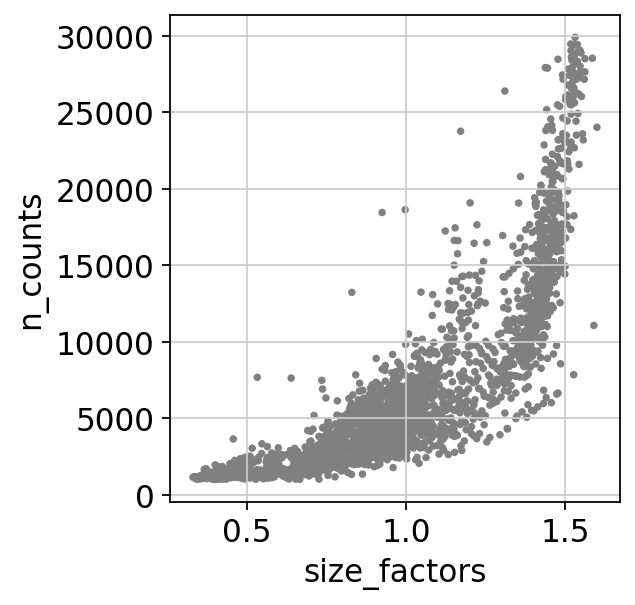

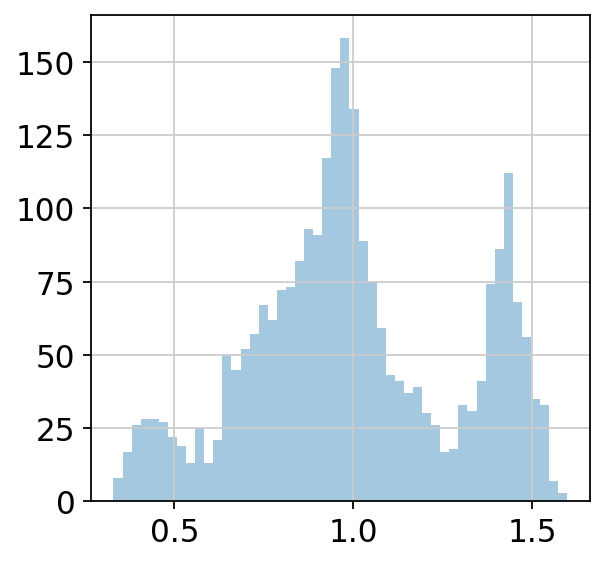

In [63]:
# Visualize the estimated size factors
adatas[9].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[9], 'size_factors', 'n_counts')

sb.distplot(size_factors, bins=50, kde=False)
pl.show()

In [64]:
#Preprocess variables for scran normalization
input_groups = adatas[10].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['sample_name']==sample_id[10]].X.T

In [65]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

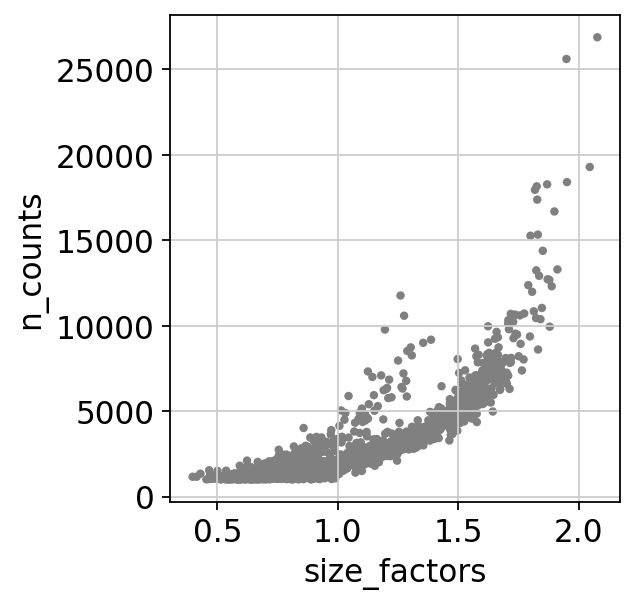

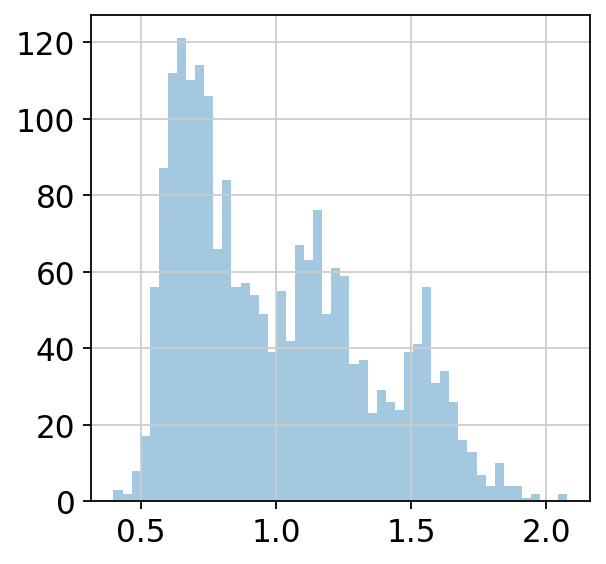

In [66]:
# Visualize the estimated size factors
adatas[10].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[10], 'size_factors', 'n_counts')

sb.distplot(size_factors, bins=50, kde=False)
pl.show()

In [67]:
#Preprocess variables for scran normalization
input_groups = adatas[11].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['sample_name']==sample_id[11]].X.T

In [68]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

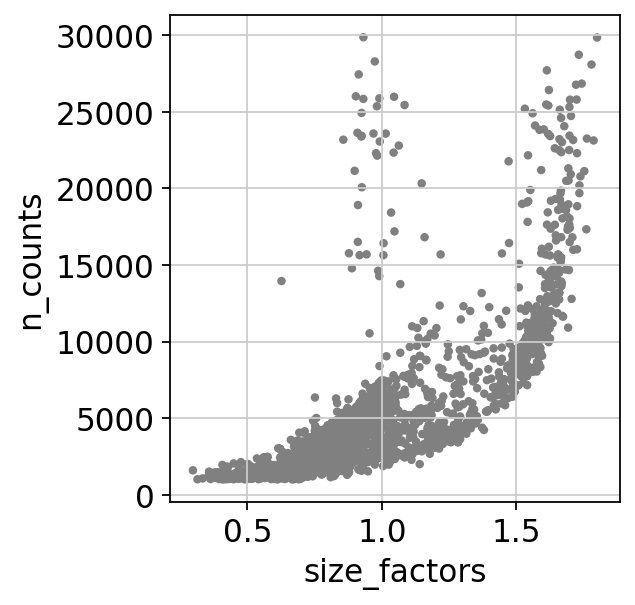

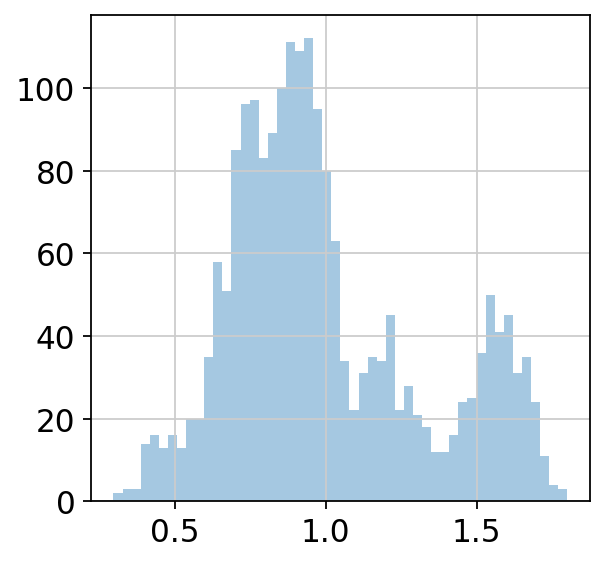

In [69]:
# Visualize the estimated size factors
adatas[11].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[11], 'size_factors', 'n_counts')

sb.distplot(size_factors, bins=50, kde=False)
pl.show()

## scale

In [70]:
adata_all = adatas[0].concatenate(adatas[1:])

Assign size factors to original data set collection.

In [71]:
adata_tmp.obs['size_factors'] = adata_all.obs['size_factors'].values

Check size factor distribution.

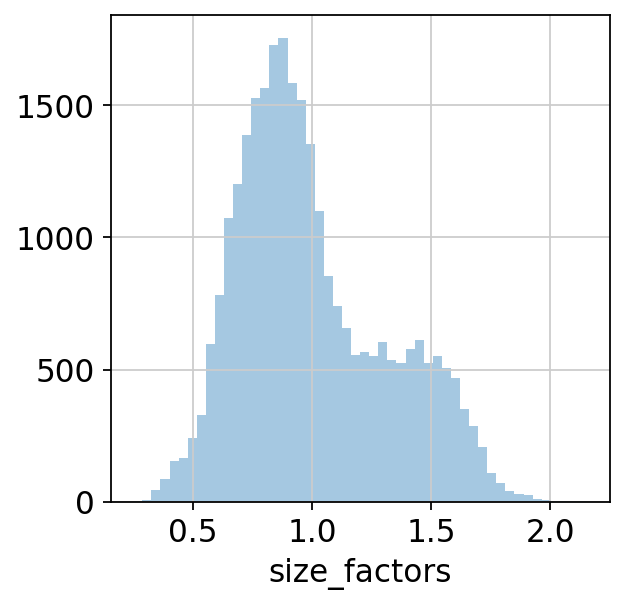

In [72]:
sb.distplot(adata_tmp.obs['size_factors'], bins=50, kde=False)
pl.show()

Filter `adata` to the same cells and genes as `adata_tmp`, then apply normalisation.

In [110]:
adata = adata[np.in1d(adata.obs_names, adata_tmp.obs_names)].copy()

In [111]:
adata = adata[:,np.in1d(adata.var_names, adata_tmp.var_names)].copy()

Save raw counts as 'counts' layer.

In [112]:
adata.layers['counts'] = adata.X.copy()

In [113]:
adata.obs['size_factors'] = adata_tmp.obs['size_factors']

In [114]:
adata

AnnData object with n_obs × n_vars = 28167 × 18928 
    obs: 'batch', 'sample_id', 'sample_name', 'baseline', 'condition', 'adult_stress', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'size_factors'
    layers: 'counts'

In [115]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

## Save to file

In [116]:
sc.write(adata=adata, filename='./../data/data_norm.h5ad')